<a href="https://colab.research.google.com/github/somosnlp/llm-arena/blob/main/An%C3%A1lisis_general_arena_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Distribución de prompts por país, 2.longitud media del prompt, .respuestas chosen y rejected por país y 3.similitud y divergengia entre respuestas chosen y rejected

In [ ]:
!pip install spacy
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 95.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Mounted at /content/drive


/tmp/ipython-input-5-53453874.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="country", order=df["country"].value_counts().index, palette="Set2")


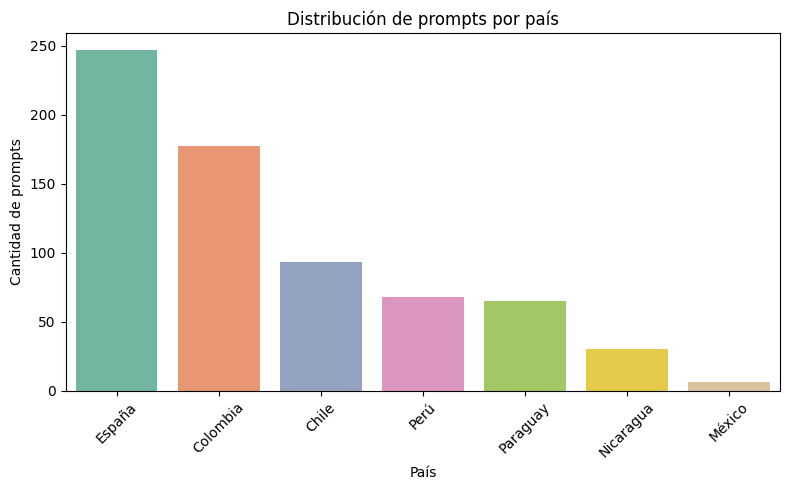

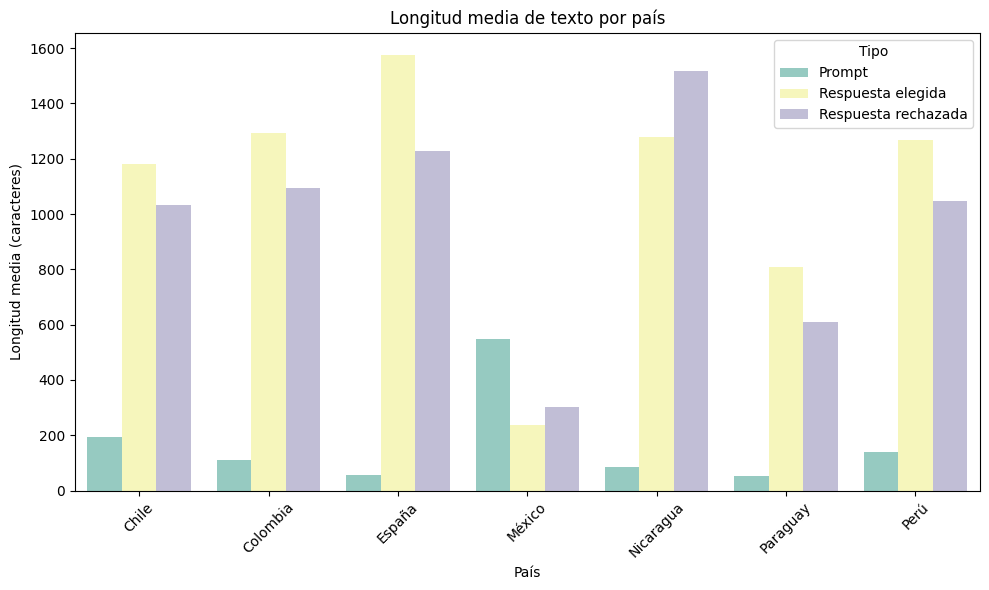

/tmp/ipython-input-5-53453874.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="country", y="similarity", palette="Set1")


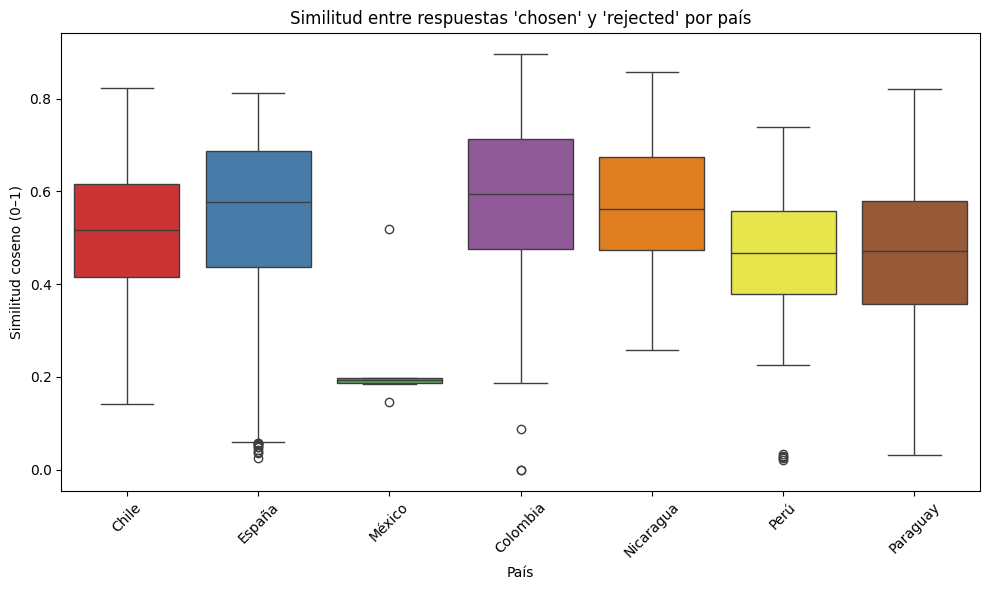


✅ Todos los gráficos han sido guardados en tu Drive: /content/drive/MyDrive/graficos_dpo


In [ ]:
# 📦 Instalar dependencias si es necesario
!pip install matplotlib seaborn scikit-learn

# 📚 Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os

# 🔗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 🗂️ Ruta donde guardarás los gráficos (ajusta si quieres usar otra carpeta)
drive_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(drive_folder, exist_ok=True)

# 📁 Cargar CSV (ajusta la ruta si lo subes manualmente en Colab)
file_path = "/content/dataset_preferencias_dpo_v0.csv"
df = pd.read_csv(file_path)

# 🎯 1. Distribución de prompts por país
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="country", order=df["country"].value_counts().index, palette="Set2")
plt.title("Distribución de prompts por país")
plt.xlabel("País")
plt.ylabel("Cantidad de prompts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{drive_folder}/distribucion_prompts_por_pais.png")
plt.show()

# ✍️ 2. Longitud media de textos por país
df["question_len"] = df["question"].str.len()
df["chosen_len"] = df["chosen"].str.len()
df["rejected_len"] = df["rejected"].str.len()

lengths = df.groupby("country")[["question_len", "chosen_len", "rejected_len"]].mean().reset_index()
lengths_melted = lengths.melt(id_vars="country", var_name="Tipo", value_name="Longitud media")
lengths_melted["Tipo"] = lengths_melted["Tipo"].map({
    "question_len": "Prompt",
    "chosen_len": "Respuesta elegida",
    "rejected_len": "Respuesta rechazada"
})

plt.figure(figsize=(10, 6))
sns.barplot(data=lengths_melted, x="country", y="Longitud media", hue="Tipo", palette="Set3")
plt.title("Longitud media de texto por país")
plt.xlabel("País")
plt.ylabel("Longitud media (caracteres)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{drive_folder}/longitud_media_por_pais.png")
plt.show()

# 🔁 3. Similitud entre 'chosen' y 'rejected'
def calcular_similitud(texto1, texto2):
    try:
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform([str(texto1), str(texto2)])
        return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    except:
        return None

df["similarity"] = df.apply(lambda row: calcular_similitud(row["chosen"], row["rejected"]), axis=1)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="country", y="similarity", palette="Set1")
plt.title("Similitud entre respuestas 'chosen' y 'rejected' por país")
plt.xlabel("País")
plt.ylabel("Similitud coseno (0–1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{drive_folder}/similitud_chosen_rejected_por_pais.png")
plt.show()

print(f"\n✅ Todos los gráficos han sido guardados en tu Drive: {drive_folder}")



In [ ]:
# 🔗 Montar Google Drive y crear carpeta
from google.colab import drive
import os

drive.mount('/content/drive')

# Carpeta donde se guardarán los gráficos
drive_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(drive_folder, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4. Análisis de temas (topic modeling) y clustering por país

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = stopwords.words("spanish")

# Agrupar todos los prompts por país
texts_by_country = df.groupby("country")["question"].apply(lambda x: " ".join(x)).to_dict()

# NMF por país
n_topics = 5
for country, text in texts_by_country.items():
    tfidf = TfidfVectorizer(stop_words=stop_words, max_features=1000)
    tfidf_matrix = tfidf.fit_transform([text])

    if tfidf_matrix.shape[1] < n_topics:
        print(f"⚠️ No hay suficientes términos únicos para generar {n_topics} tópicos en {country}.")
        continue

    nmf = NMF(n_components=n_topics, random_state=42)
    W = nmf.fit_transform(tfidf_matrix)
    H = nmf.components_
    vocab = tfidf.get_feature_names_out()

    # Visualización
    fig, axes = plt.subplots(1, n_topics, figsize=(16, 4))
    for i, topic in enumerate(H):
        top_words = [vocab[j] for j in topic.argsort()[-7:][::-1]]
        axes[i].barh(top_words[::-1], topic[topic.argsort()[-7:]])
        axes[i].set_title(f"Tópico {i+1}")
    fig.suptitle(f"Tópicos más frecuentes – {country}")
    plt.tight_layout()
    plt.savefig(f"{drive_folder}/topics_{country}.png")
    plt.close()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:133: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(res * 2)
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:133: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(res * 2)
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:133: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(res * 2)
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:133: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(res * 2)


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dataset_preferencias_dpo_v0.csv to dataset_preferencias_dpo_v0 (1).csv


In [ ]:
import pandas as pd

df = pd.read_csv("dataset_preferencias_dpo_v0.csv")  # Reemplaza con el nombre exacto si es otro
df.head()  # Para ver las primeras filas y confirmar que se cargó bien


,country,system_prompt,question,chosen,rejected
0,Chile,Una conversación entre un usuario y un modelo ...,Situación:\n\nEres un chileno caminando por Es...,"¡Uf, compadre! Caminando por Estación Central ...","En una situación así, la sensación que podrías..."
1,Chile,Una conversación entre un usuario y un modelo ...,hola que tal,"¡Hola! Muy bien, gracias por preguntar. ¿En qu...","Hola, estoy bien, gracias. ¿En qué puedo ayuda..."
2,Chile,Una conversación entre un usuario y un modelo ...,Imagina que vas en el Metro de Santiago de Chi...,"¡Qué situación más particular! A ver, consider...",Basado en lo que se conoce sobre el fenómeno d...
3,Chile,Una conversación entre un usuario y un modelo ...,Eres Venezolano de toda tu vida y vas por prim...,El Festival de Viña del Mar es uno de los even...,"Como asistente de lenguaje, no tengo una nacio..."
4,Chile,Una conversación entre un usuario y un modelo ...,Eres Viña Marino de toda tu vida y estás en el...,Como Viñamarino de toda la vida y estando en e...,"En el Festival de Viña del Mar, la reacción de..."


# 6. Frecuencia de palabras y expresiones locales por país

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import string

# Lista de stopwords en español
stop_words = set(stopwords.words("spanish"))
punct = set(string.punctuation)

def contar_palabras_basico(textos):
    palabras = []
    for texto in textos:
        tokens = str(texto).lower().split()
        tokens = [t.strip("".join(punct)) for t in tokens if t.isalpha() and t not in stop_words]
        palabras.extend(tokens)
    return Counter(palabras)

# Crear gráficas para cada país
for pais in df["country"].unique():
    subset = df[df["country"] == pais]["chosen"]
    freqs = contar_palabras_basico(subset)
    top = freqs.most_common(10)
    if not top:
        continue
    palabras, cuentas = zip(*top)

    plt.figure(figsize=(8,4))
    sns.barplot(x=list(cuentas), y=list(palabras), palette="viridis")
    plt.title(f"Top 10 palabras más frecuentes en {pais}")
    plt.xlabel("Frecuencia")
    plt.tight_layout()
    plt.savefig(f"{drive_folder}/frecuencia_palabras_{pais}.png")
    plt.close()

print("✅ Gráficos de frecuencia de palabras guardados en tu Drive.")


/tmp/ipython-input-9-1581555898.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cuentas), y=list(palabras), palette="viridis")
/tmp/ipython-input-9-1581555898.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cuentas), y=list(palabras), palette="viridis")
/tmp/ipython-input-9-1581555898.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cuentas), y=list(palabras), palette="viridis")
/tmp/ipython-input-9-1581555898.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remove

✅ Gráficos de frecuencia de palabras guardados en tu Drive.


# 7. Análisis de estilo narrativo, modismos, y formalidad entre chosen y rejected

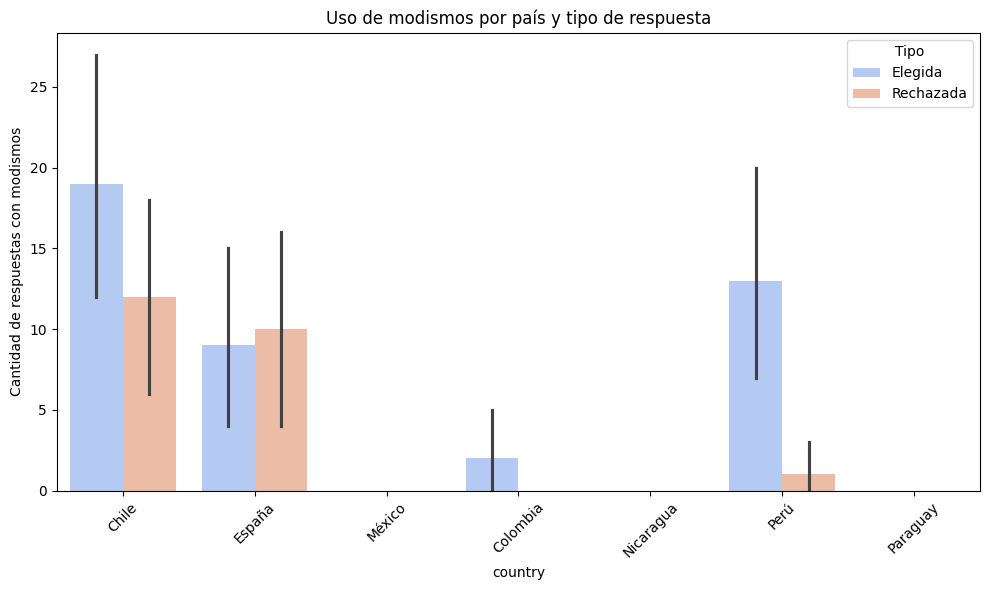

In [ ]:
import spacy
nlp = spacy.load("es_core_news_sm")

def extraer_estilo(texto):
    doc = nlp(str(texto))
    tokens = [token.text.lower() for token in doc]
    tiene_modismo = any(w in tokens for w in ["weón", "cachai", "chévere", "tío", "pata", "guay"])
    segunda_persona = "tú" in tokens or "usted" in tokens
    primera_persona = any(tok.text.lower() in ["yo", "nosotros"] for tok in doc if tok.pos_ == "PRON")
    imperativos = sum(1 for tok in doc if tok.pos_ == "VERB" and "Imp" in tok.morph.get("Mood"))
    return pd.Series({
        "modismo": tiene_modismo,
        "segunda_persona": segunda_persona,
        "primera_persona": primera_persona,
        "imperativos": imperativos
    })

df_chosen = df["chosen"].apply(extraer_estilo).add_prefix("chosen_")
df_rejected = df["rejected"].apply(extraer_estilo).add_prefix("rejected_")
df_estilo = pd.concat([df["country"], df_chosen, df_rejected], axis=1)

# Gráfico: uso de modismos en chosen vs rejected
df_plot = df_estilo[["country", "chosen_modismo", "rejected_modismo"]].melt(
    id_vars="country", var_name="Tipo", value_name="Uso")
df_plot["Tipo"] = df_plot["Tipo"].map({
    "chosen_modismo": "Elegida",
    "rejected_modismo": "Rechazada"
})

plt.figure(figsize=(10,6))
sns.barplot(data=df_plot, x="country", y="Uso", hue="Tipo", palette="coolwarm", estimator=sum)
plt.title("Uso de modismos por país y tipo de respuesta")
plt.ylabel("Cantidad de respuestas con modismos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{drive_folder}/modismos_por_pais.png")
plt.show()



# 8. Clasificación de prompts (clustering, clasificación no supervisada)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


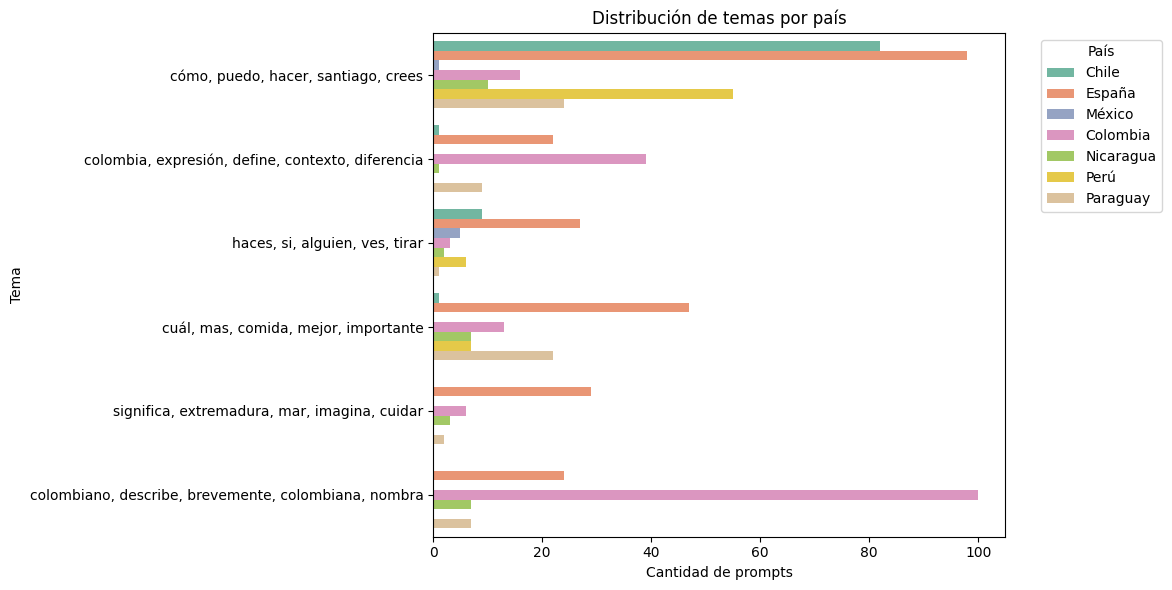

✅ CSV con temas guardado en: /content/drive/MyDrive/graficos_dpo/dataset_con_temas.csv


In [ ]:
# 📦 Instalar dependencias necesarias
!pip install -q pandas scikit-learn matplotlib seaborn nltk

# 📚 Importar librerías
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

# 🛑 Stopwords en español
spanish_stopwords = stopwords.words("spanish")

# 📁 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Carpeta para guardar
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📥 Cargar CSV
file_path = "/content/dataset_preferencias_dpo_v0.csv"
df = pd.read_csv(file_path)
df.dropna(subset=["question"], inplace=True)

# 🧠 TF-IDF
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=spanish_stopwords, max_features=1000)
tfidf = vectorizer.fit_transform(df["question"])

# 🧪 Topic modeling con NMF
n_topics = 6
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(tfidf)
H = nmf.components_

# 🏷️ Etiquetas
df["topic_id"] = W.argmax(axis=1)
feature_names = vectorizer.get_feature_names_out()
topic_keywords = [", ".join([feature_names[i] for i in topic.argsort()[-5:][::-1]]) for topic in H]
df["topic_label"] = df["topic_id"].apply(lambda i: topic_keywords[i])

# 📊 Gráfico de temas por país
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y="topic_label", hue="country", palette="Set2")
plt.title("Distribución de temas por país")
plt.xlabel("Cantidad de prompts")
plt.ylabel("Tema")
plt.legend(title="País", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{output_folder}/temas_por_pais.png")
plt.show()

# 💾 Guardar CSV con temas asignados
df.to_csv(f"{output_folder}/dataset_con_temas.csv", index=False)
print("✅ CSV con temas guardado en:", f"{output_folder}/dataset_con_temas.csv")



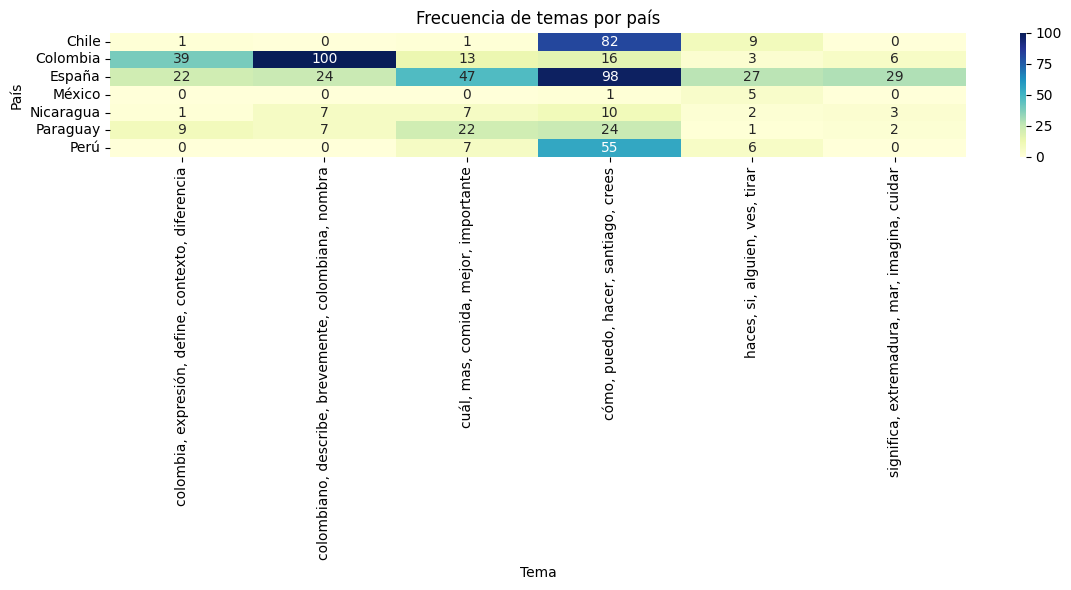

✅ Heatmap guardado en: /content/drive/MyDrive/graficos_dpo/heatmap_temas_por_pais.png


In [ ]:
# 📋 Tabla resumen: cantidad de prompts por país y tema
tabla_resumen = df.groupby(["country", "topic_label"]).size().unstack(fill_value=0)

# 🔥 Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(tabla_resumen, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Frecuencia de temas por país")
plt.xlabel("Tema")
plt.ylabel("País")
plt.tight_layout()

# 💾 Guardar en Drive
heatmap_path = f"{output_folder}/heatmap_temas_por_pais.png"
plt.savefig(heatmap_path)
plt.show()

print("✅ Heatmap guardado en:", heatmap_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

file_path = "/content/dataset_preferencias_dpo_v0.csv"  # Ajusta la ruta si estás usando Drive

try:
    df = pd.read_csv(file_path, sep=",", encoding="utf-8")
except pd.errors.ParserError:
    df = pd.read_csv(file_path, sep=";", encoding="utf-8")
except Exception as e:
    print(f"Otro error al leer CSV: {e}")

# Elimina filas incompletas
df.dropna(subset=["question", "chosen", "rejected"], inplace=True)


In [ ]:
df.head()
df.columns


Index(['country', 'system_prompt', 'question', 'chosen', 'rejected'], dtype='object')

# Clasificación de prompts semisupervisada usando transformers

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


🔎 Clasificando prompts...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


🔎 Clasificando respuestas CHOSEN...
🔎 Clasificando respuestas REJECTED...


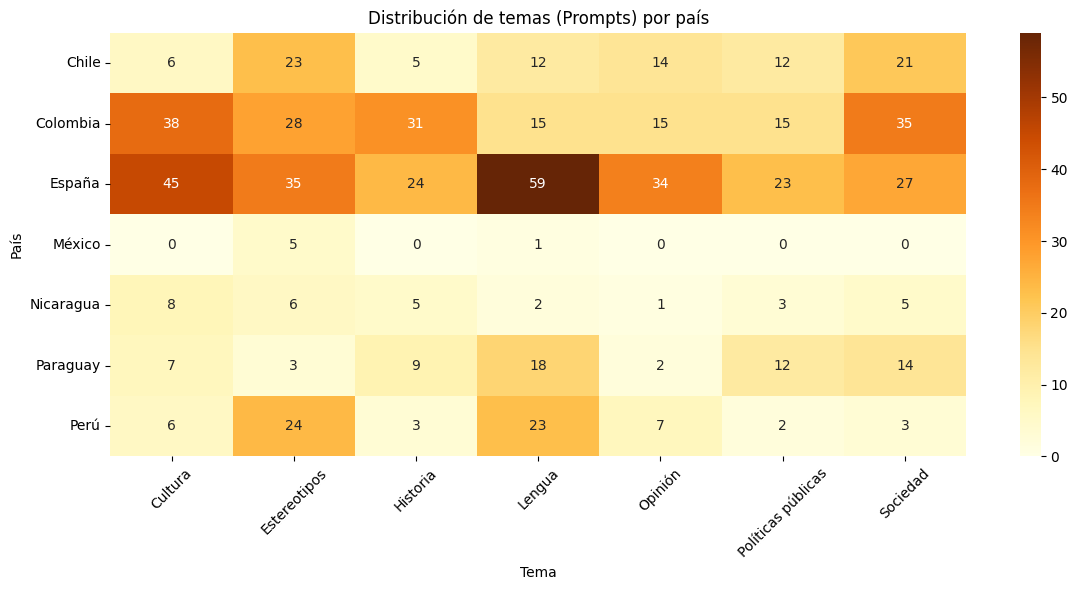

✅ Heatmap de Prompts guardado en: /content/drive/MyDrive/graficos_dpo/heatmap_temas_prompts.png


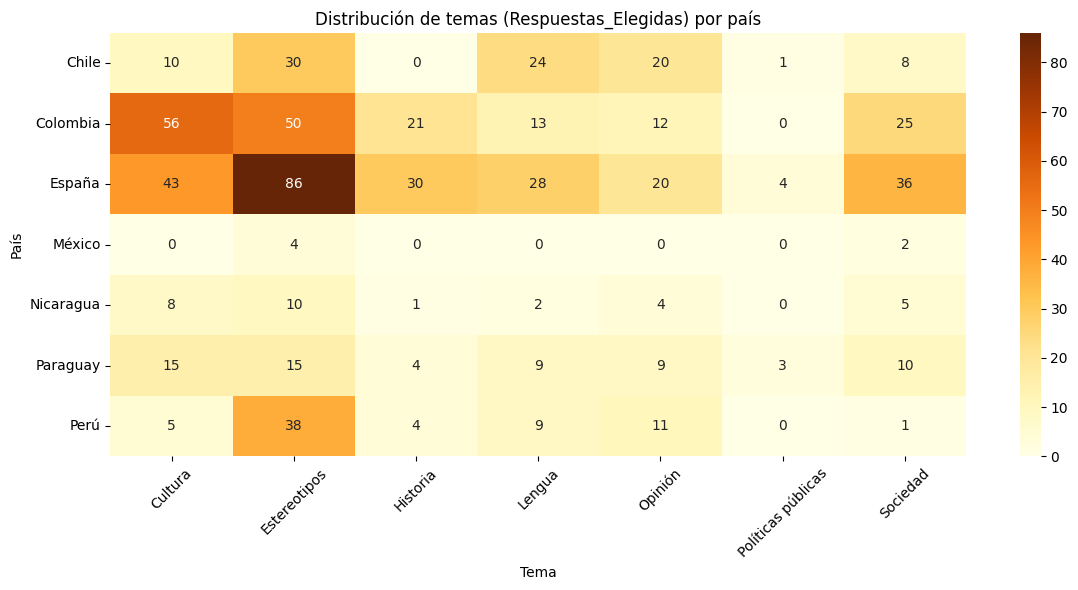

✅ Heatmap de Respuestas_Elegidas guardado en: /content/drive/MyDrive/graficos_dpo/heatmap_temas_respuestas_elegidas.png


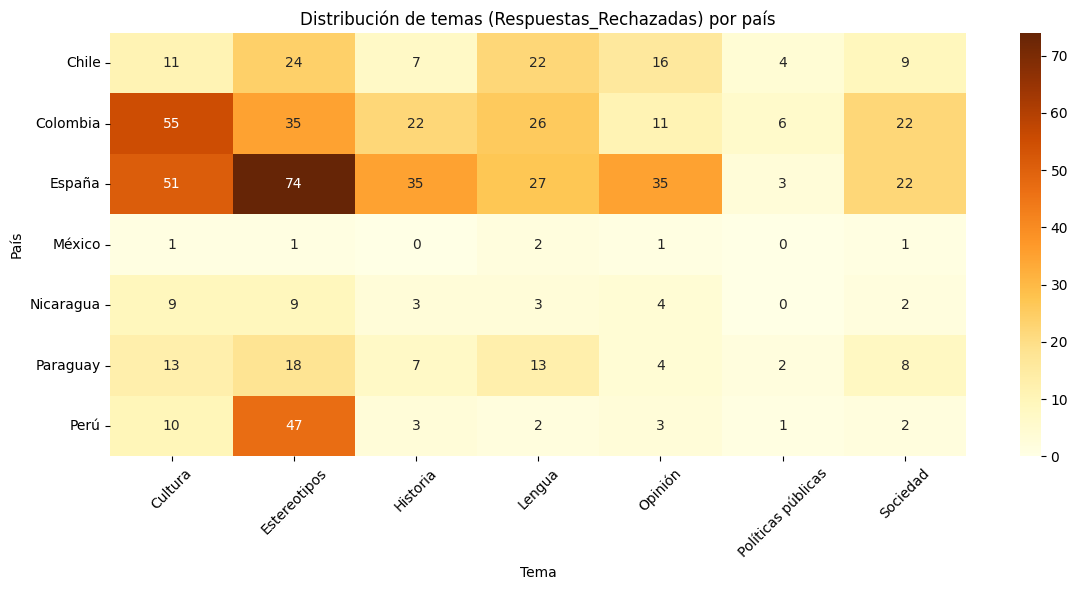

✅ Heatmap de Respuestas_Rechazadas guardado en: /content/drive/MyDrive/graficos_dpo/heatmap_temas_respuestas_rechazadas.png
✅ Todo el análisis y las visualizaciones han sido guardados en Drive: /content/drive/MyDrive/graficos_dpo


In [ ]:
# 📦 Instalar dependencias necesarias
!pip install -q transformers datasets torch

# 📚 Importar librerías
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 📁 Montar Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Carpeta de salida en Drive
output_folder = "/content/drive/MyDrive/graficos_dpo"
os.makedirs(output_folder, exist_ok=True)

# 📥 Cargar dataset
file_path = "/content/dataset_preferencias_dpo_v0.csv"
df = pd.read_csv(file_path)
df.dropna(subset=["question", "chosen", "rejected"], inplace=True)

# 🏷️ Definir categorías temáticas
etiquetas = ["Cultura", "Sociedad", "Lengua", "Historia", "Estereotipos", "Opinión", "Políticas públicas"]

# 🧠 Cargar clasificador multilingüe
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# 🧪 Función de clasificación
def clasificar_texto(texto):
    try:
        resultado = classifier(texto, etiquetas)
        return resultado["labels"][0]
    except:
        return "Otro"

# 🔍 Clasificar cada texto
print("🔎 Clasificando prompts...")
df["tema_prompt"] = df["question"].apply(clasificar_texto)

print("🔎 Clasificando respuestas CHOSEN...")
df["tema_chosen"] = df["chosen"].apply(clasificar_texto)

print("🔎 Clasificando respuestas REJECTED...")
df["tema_rejected"] = df["rejected"].apply(clasificar_texto)

# 💾 Guardar CSV con las etiquetas
etiquetado_csv = f"{output_folder}/dataset_clasificado_temas.csv"
df.to_csv(etiquetado_csv, index=False)

# 📊 Crear función para visualización por tipo
def graficar_heatmap(df, columna_tema, nombre, carpeta):
    resumen = df.groupby(["country", columna_tema]).size().unstack(fill_value=0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(resumen, annot=True, fmt="d", cmap="YlOrBr", cbar=True)
    plt.title(f"Distribución de temas ({nombre}) por país")
    plt.xlabel("Tema")
    plt.ylabel("País")
    plt.xticks(rotation=45)
    plt.tight_layout()
    output_path = f"{carpeta}/heatmap_temas_{nombre.lower()}.png"
    plt.savefig(output_path)
    plt.show()
    print(f"✅ Heatmap de {nombre} guardado en:", output_path)

# 📊 Generar y guardar heatmaps
graficar_heatmap(df, "tema_prompt", "Prompts", output_folder)
graficar_heatmap(df, "tema_chosen", "Respuestas_Elegidas", output_folder)
graficar_heatmap(df, "tema_rejected", "Respuestas_Rechazadas", output_folder)

print("✅ Todo el análisis y las visualizaciones han sido guardados en Drive:", output_folder)


# Temáticas con mayor respuestas aceptadas (chosen)

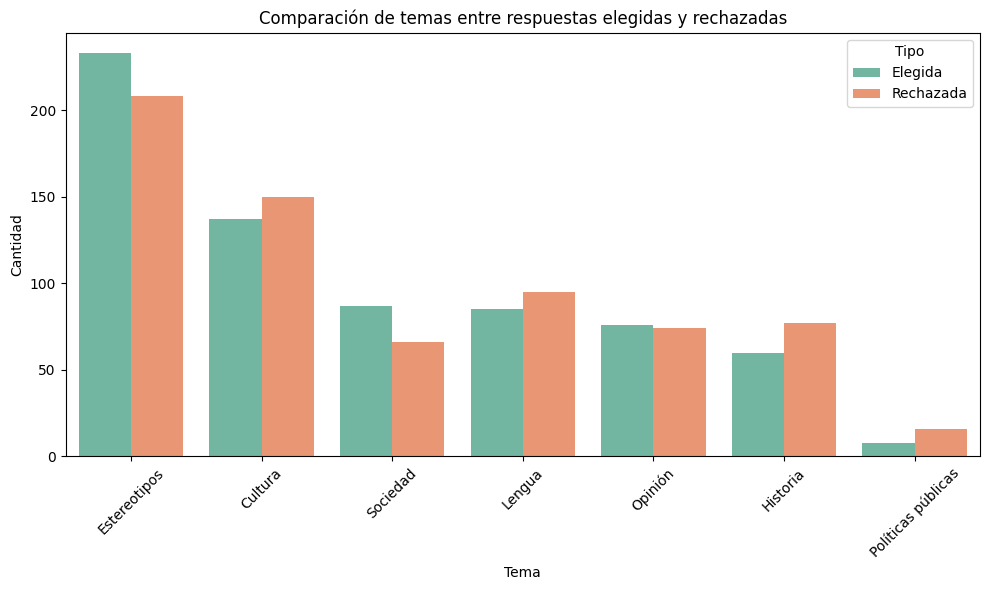

✅ Gráfico global guardado en Drive.
✅ Guardado gráfico para Chile: /content/drive/MyDrive/graficos_dpo/comparacion_temas_chile.png
✅ Guardado gráfico para España: /content/drive/MyDrive/graficos_dpo/comparacion_temas_españa.png
✅ Guardado gráfico para México: /content/drive/MyDrive/graficos_dpo/comparacion_temas_méxico.png
✅ Guardado gráfico para Colombia: /content/drive/MyDrive/graficos_dpo/comparacion_temas_colombia.png
✅ Guardado gráfico para Nicaragua: /content/drive/MyDrive/graficos_dpo/comparacion_temas_nicaragua.png
✅ Guardado gráfico para Perú: /content/drive/MyDrive/graficos_dpo/comparacion_temas_perú.png
✅ Guardado gráfico para Paraguay: /content/drive/MyDrive/graficos_dpo/comparacion_temas_paraguay.png


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 📂 Carpeta donde se guardarán las gráficas
output_folder = "/content/drive/MyDrive/graficos_dpo"

# 🔄 Crear tabla resumen de temas por tipo de respuesta
def preparar_tabla_comparativa(df, columna, tipo):
    conteo = df[columna].value_counts().reset_index()
    conteo.columns = ["Tema", "Cantidad"]
    conteo["Tipo"] = tipo
    return conteo

# 📊 Resumen global
tabla_chosen = preparar_tabla_comparativa(df, "tema_chosen", "Elegida")
tabla_rejected = preparar_tabla_comparativa(df, "tema_rejected", "Rechazada")
tabla_comparativa = pd.concat([tabla_chosen, tabla_rejected])

# 📈 Visualización general
plt.figure(figsize=(10, 6))
sns.barplot(data=tabla_comparativa, x="Tema", y="Cantidad", hue="Tipo", palette="Set2")
plt.title("Comparación de temas entre respuestas elegidas y rechazadas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_folder}/comparacion_temas_chosen_rejected_global.png")
plt.show()

print("✅ Gráfico global guardado en Drive.")

# 📊 Comparación por país (opcional: más detallado)
def comparar_por_pais(df, output_folder):
    paises = df["country"].unique()
    for pais in paises:
        subset = df[df["country"] == pais]
        chosen = preparar_tabla_comparativa(subset, "tema_chosen", "Elegida")
        rejected = preparar_tabla_comparativa(subset, "tema_rejected", "Rechazada")
        comp = pd.concat([chosen, rejected])

        plt.figure(figsize=(10, 5))
        sns.barplot(data=comp, x="Tema", y="Cantidad", hue="Tipo", palette="Set3")
        plt.title(f"Comparación de temas por tipo de respuesta – {pais}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        nombre_archivo = f"{output_folder}/comparacion_temas_{pais.lower()}.png"
        plt.savefig(nombre_archivo)
        plt.close()
        print(f"✅ Guardado gráfico para {pais}: {nombre_archivo}")

# Ejecutar comparación por país
comparar_por_pais(df, output_folder)


# Tabla con los temas más recurrentes por país

In [ ]:
import pandas as pd
import os

# Ruta de salida en Google Drive
output_path = "/content/drive/MyDrive/graficos_dpo/temas_por_pais.csv"

# Agrupar por país y tema del prompt
tabla_temas = (
    df.groupby(['country', 'tema_prompt'])
    .size()
    .reset_index(name='Frecuencia')
    .sort_values(['country', 'Frecuencia'], ascending=[True, False])
)

# Guardar en Drive
tabla_temas.to_csv(output_path, index=False)

print(f"✅ Tabla de temas por país guardada en: {output_path}")


✅ Tabla de temas por país guardada en: /content/drive/MyDrive/graficos_dpo/temas_por_pais.csv


# Gráfico de temas más frecuentes globalmente

/tmp/ipython-input-11-717049587.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-11-717049587.py:31: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-717049587.py:34: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


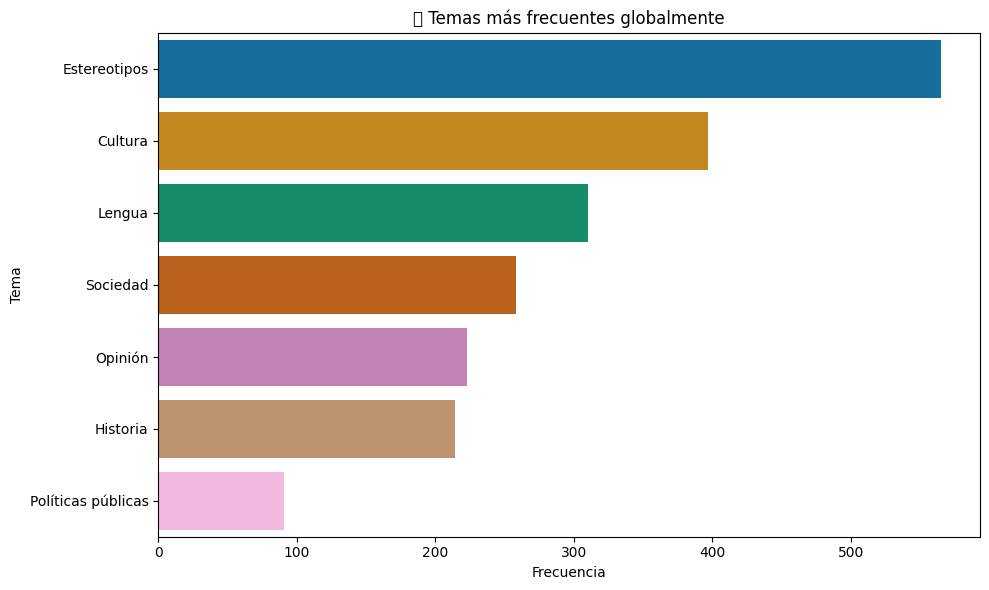

✅ Gráfico guardado en: /content/drive/MyDrive/graficos_dpo/temas_frecuencia_global.png


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ruta de guardado en Drive
output_path = "/content/drive/MyDrive/graficos_dpo/temas_frecuencia_global.png"

# 🧱 Unir todos los temas en una sola serie
temas_combinados = pd.concat([
    df["tema_prompt"],
    df["tema_chosen"],
    df["tema_rejected"]
])

# 🧮 Contar frecuencia total por tema
frecuencias_globales = temas_combinados.value_counts().reset_index()
frecuencias_globales.columns = ["Tema", "Frecuencia"]

# 🎨 Gráfico de barras horizontal con paleta daltónica
plt.figure(figsize=(10, 6))
sns.barplot(
    data=frecuencias_globales,
    y="Tema",
    x="Frecuencia",
    palette="colorblind"
)
plt.title("🧠 Temas más frecuentes globalmente")
plt.xlabel("Frecuencia")
plt.ylabel("Tema")
plt.tight_layout()

# 💾 Guardar gráfico
plt.savefig(output_path)
plt.show()

print(f"✅ Gráfico guardado en: {output_path}")
